In [1]:
#Mount the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [4]:
%cd drive/MyDrive/Colab\ Notebooks/Sprint18


/content/drive/MyDrive/Colab Notebooks/Sprint18


### 【問題1】自作データセットでの分類の学習
### 【問題2】分類データセットに対するデータ拡張


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt


In [10]:
# データが存在するフォルダを設定
train_dir = r"./train"
validation_dir = r"./validation"
train_cat_dir = r"./train/train_cat"
validation_cat_dir = r"./validation/validation_cat"
train_dog_dir = r"./train/train_dog"
validation_dog_dir = r"./validation/validation_dog"

# フォルダが認識されているか確認
num_cats_trn = len(os.listdir(train_cat_dir))
num_cats_val = len(os.listdir(validation_cat_dir))
num_dogs_trn = len(os.listdir(train_dog_dir))
num_dogs_val = len(os.listdir(validation_dog_dir))
total_train = num_cats_trn + num_dogs_trn
total_validation = num_cats_val + num_dogs_val
print(num_cats_trn)     # 3
print(num_cats_val)     # 2
print(num_dogs_trn)     # 3
print(num_dogs_val)     # 2
print("----------")
print("Total train images : ", total_train)         # 6
print("Total validation images : ", total_validation)    # 4


3
2
3
2
----------
Total train images :  6
Total validation images :  4


In [11]:
# データの前処理、学習に使用する変数を設定
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150


In [12]:
# 前処理[1]：ジェネレータクラスの定義
# 1. ディスクから画像を読み取る
# 2. 読み取った画像をデコードし、RGB値に従って適切なグリッド形式へ変換
# 3. 浮動小数点のテンソルへ変換
# 4. テンソルを0～255の値から0～1の値へ正規化
# 上記1～4は(tf.keras.)ImageDataGeneratorクラスで実行できる
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)


In [13]:
# 前処理[2]：ジェネレータクラスのメソッド「flow_from_directory」を使用
# 「flow_from_directory」により、ディスクから画像をロードし、正規化
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="binary")

validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=validation_dir,
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode="binary")


Found 6 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


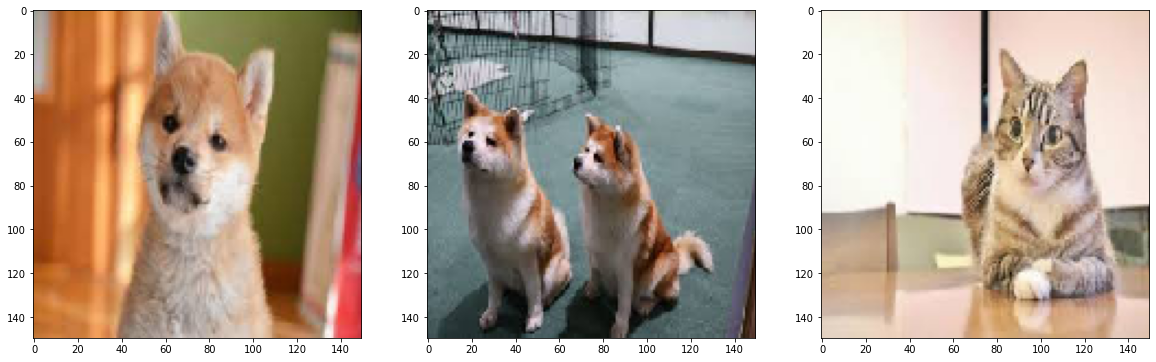

In [14]:
# 学習用画像の可視化
# next関数を使用してデータセットから(x_train, y_train)の形式でバッチを返す。
sample_train_images, _ = next(train_data_gen)

plt.figure(figsize=(20, 20))                    # 表示する画像のサイズを設定
for i in range(len(sample_train_images)):       # next関数の返り値(x_train)分ループ
    if i < 3:                                   # 確認のみであるため、表示数を限定(3)
        plt.subplot(1, 3, i+1)                  # 1行3列で画像を表示
        plt.imshow(sample_train_images[i])      # 対象画像を表示
    else:
        break                                   # 3枚以上は表示しない(ループを抜ける)


In [15]:
# モデルの構築
# MaxPooling層を伴う3つの畳み込みブロック
# relu活性化関数によるアクティベーション512ユニットの全結合層
# シグモイド活性化関数による二値分類
model = Sequential([
    Conv2D(16, 3, padding="same", activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1, activation="sigmoid")
])


In [16]:
# モデルのコンパイル
# ADAMオプティマイザー、クロスエントロピー誤差
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [17]:
# モデルの概要
# summaryメソッドで全てのネットワークレイヤーを確認
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [18]:
# モデルの学習
# # ImageDataGeneratorクラスのfit_generatorメソッドを使用して、学習
# history = model.fit_generator(
#     train_data_gen,
#     steps_per_epoch=total_train,            # batch_size
#     epochs=epochs,
#     validation_data=validation_data_gen,    # 
#     validation_steps=total_validation       # batch_size
# )

history = model.fit_generator(generator=train_data_gen,
                              epochs=epochs,
                              validation_data=validation_data_gen)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
1/1 [==============================] - 4s 4s/step - loss: 0.7040 - accuracy: 0.5000 - val_loss: 1.8162 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 488ms/step - loss: 1.5528 - accuracy: 0.5000 - val_loss: 0.6755 - val_accuracy: 0.5000
Epoch 3/15
1/1 [==============================] - 0s 458ms/step - loss: 0.5603 - accuracy: 1.0000 - val_loss: 0.8367 - val_accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 1s 508ms/step - loss: 0.7940 - accuracy: 0.5000 - val_loss: 0.7077 - val_accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 0s 442ms/step - loss: 0.5811 - accuracy: 0.5000 - val_loss: 0.6633 - val_accuracy: 0.7500
Epoch 6/15
1/1 [==============================] - 1s 507ms/step - loss: 0.4549 - accuracy: 1.0000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 0s 456ms/step - loss: 0.4012 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 8/15
1/1 [=======

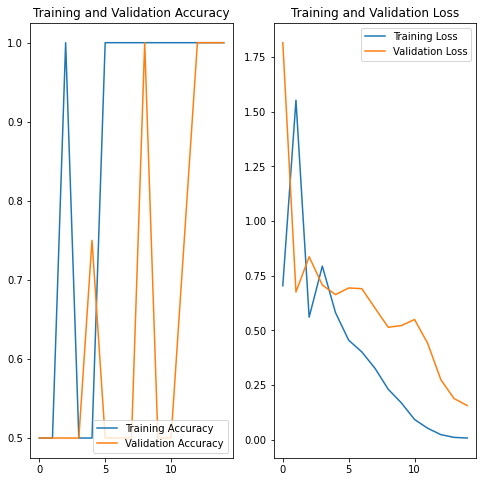

In [19]:
# 学習結果の可視化
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
# データ拡張
# 学習用データに対して、リスケール、45度の回転、幅シフト、高さシフト、水平反転、ズーム、を適用
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

# データ拡張により学習用データを増やしたので、再度、画像をロードし、正規化
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="binary")


Found 6 images belonging to 2 classes.


In [21]:
# 検証データジェネレータに対してはリスケールのみを行う（一般的にデータ拡張は学習データのみに行う）
image_gen_val = ImageDataGenerator(rescale=1./255)

# データ拡張したので、再度、画像をロードし、正規化
validation_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                         directory=validation_dir,
                                                         shuffle=True,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode="binary")


Found 4 images belonging to 2 classes.


In [22]:
# 拡張したデータで、モデルをコンパイル
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [23]:
# モデルの学習
history = model.fit_generator(generator=train_data_gen,
                              epochs=epochs,
                              validation_data=validation_data_gen)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 3.8785 - val_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 0s 449ms/step - loss: 0.5752 - accuracy: 0.6667 - val_loss: 0.1765 - val_accuracy: 1.0000
Epoch 3/15
1/1 [==============================] - 0s 490ms/step - loss: 7.4334e-04 - accuracy: 1.0000 - val_loss: 1.7084 - val_accuracy: 0.5000
Epoch 4/15
1/1 [==============================] - 0s 453ms/step - loss: 0.7469 - accuracy: 0.5000 - val_loss: 0.4740 - val_accuracy: 0.7500
Epoch 5/15
1/1 [==============================] - 0s 484ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.2395 - val_accuracy: 1.0000
Epoch 6/15
1/1 [==============================] - 0s 448ms/step - loss: 8.7468e-04 - accuracy: 1.0000 - val_loss: 0.4543 - val_accuracy: 0.7500
Epoch 7/15
1/1 [==============================] - 0s 499ms/step - loss: 7.3423e-04 - accuracy: 1.0000 - val_loss: 0.8487 - val_accuracy: 0.5000
Epoch 8/15


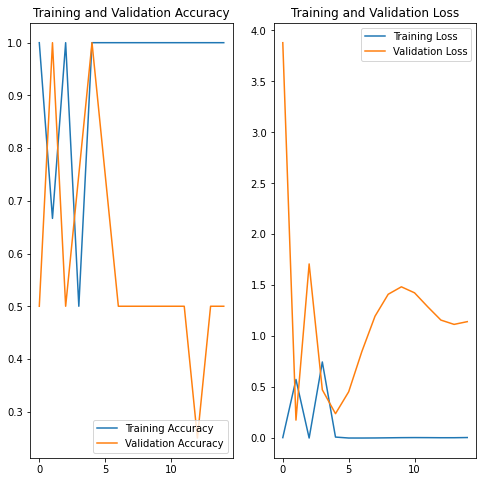

In [24]:
# 学習結果の可視化
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 【問題3】物体検出データセットの用意
### 【問題4】物体検出データセットに対するデータ拡張


In [5]:
from PIL import Image
import numpy as np
import numpy  as np
import os
import glob 
import re
import matplotlib.pyplot as plt
import cv2
from PIL import Image
%matplotlib inline

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 2, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 2,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(7, 7))
    plt.imshow(img)


In [6]:
def download_image(url):
    data = open(url,"rb").read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


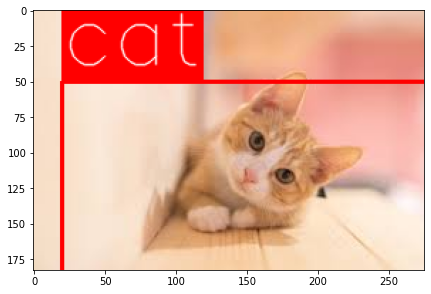

In [25]:
image = download_image(r"./train/train_cat/cat01.jpg")
image = np.array(image)

annotations = {'image': image, 'bboxes': [[20,50,1000,1000]], 'category_id': [0]}
category_id_to_name = {0: 'cat', 1: 'dog'}
img = visualize(annotations, category_id_to_name)


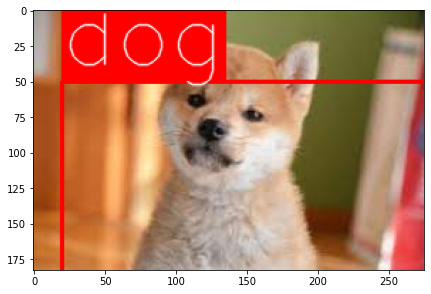

In [26]:
image = download_image(r"./train/train_dog/dog01.jpg")
image = np.array(image)

annotations = {'image': image, 'bboxes': [[20,50,700,700]], 'category_id': [1]}
category_id_to_name = {0: 'cat', 1: 'dog'}
img = visualize(annotations, category_id_to_name)

In [27]:
import albumentations as A


In [29]:
aug = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])
